## **sim that trade!**

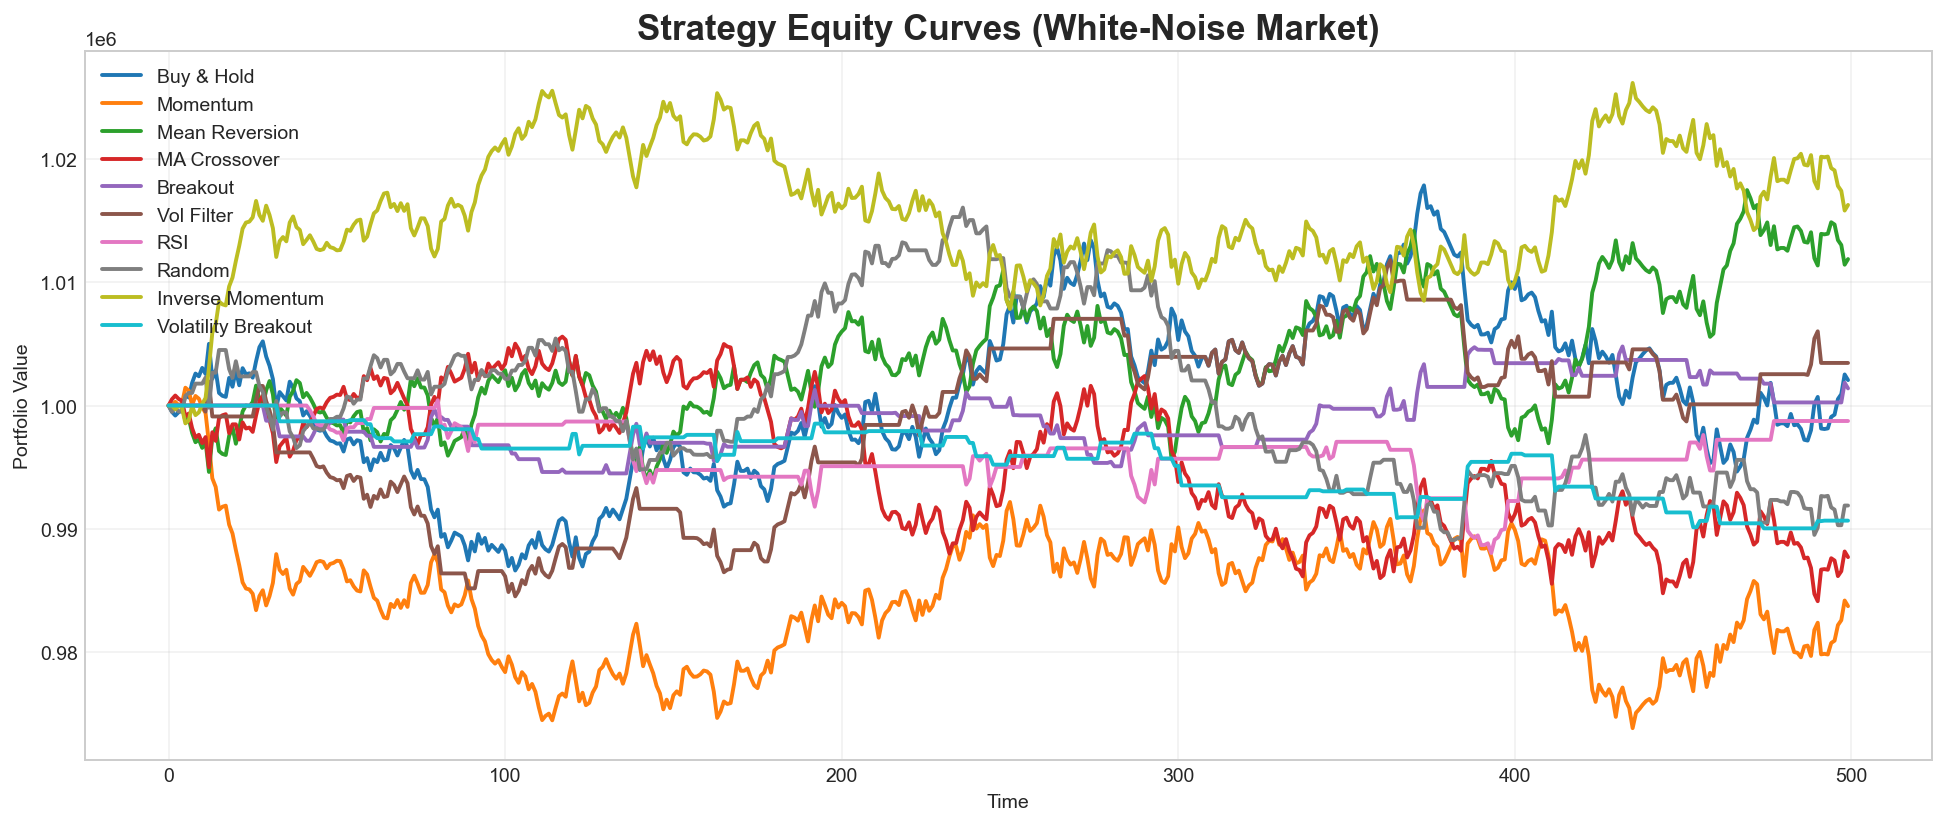


===== PERFORMANCE SUMMARY =====
                     Final Equity  Return %  Max Drawdown  Sharpe
Buy & Hold           1.002068e+06    0.2068    23248.3751  0.0044
Momentum             9.837035e+05   -1.6296    27657.0872 -0.0300
Mean Reversion       1.011898e+06    1.1898    17242.3048  0.0230
MA Crossover         9.876876e+05   -1.2312    21490.9342 -0.0228
Breakout             1.001393e+06    0.1393     6204.4591  0.0062
Vol Filter           1.003461e+06    0.3461    17452.4216  0.0093
RSI                  9.987445e+05   -0.1255    12409.6245 -0.0046
Random               9.918764e+05   -0.8124    27008.9760 -0.0184
Inverse Momentum     1.016296e+06    1.6296    17735.4993  0.0315
Volatility Breakout  9.906510e+05   -0.9349     9976.5043 -0.0495


In [12]:
# ============================================================
# backtester.py — full standalone mini backtesting framework
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-whitegrid")
# np.random.seed(42)


# ============================================================
# 1) MARKET SIMULATOR
# ============================================================

def generate_white_noise_prices(n=500, S0=100, vol=0.01):
    """Simple white-noise price generator"""
    returns = np.random.normal(0, vol, n)
    prices = S0 * np.cumprod(1 + returns)
    df = pd.DataFrame({"price": prices})
    df.index.name = "t"
    return df


# ============================================================
# 2) STRATEGIES (10 total)
# ============================================================

# 1. Buy & hold
def strat_buy_and_hold(df):
    return pd.Series(1, index=df.index)

# 2. Momentum (1-day)
def strat_momentum(df):
    sig = np.sign(df["price"].diff())
    sig.iloc[0] = 0
    return sig

# 3. Mean reversion
def strat_mean_reversion(df, window=5):
    ma = df["price"].rolling(window).mean()
    sig = -np.sign(df["price"] - ma)
    sig.fillna(0, inplace=True)
    return sig

# 4. Moving average crossover
def strat_ma_crossover(df, fast=5, slow=20):
    ma_fast = df["price"].rolling(fast).mean()
    ma_slow = df["price"].rolling(slow).mean()
    sig = np.where(ma_fast > ma_slow, 1, -1)
    sig = pd.Series(sig, index=df.index)
    sig[slow-1] = 0
    return sig

# 5. Breakout strategy
def strat_breakout(df, window=20):
    high = df["price"].rolling(window).max()
    low = df["price"].rolling(window).min()
    sig = np.where(df["price"] > high.shift(1), 1,
          np.where(df["price"] < low.shift(1), -1, 0))
    return pd.Series(sig, index=df.index)

# 6. Volatility filter (only trade when vol low)
def strat_vol_filter(df, window=10):
    vol = df["price"].pct_change().rolling(window).std()
    sig = np.where(vol < vol.median(), 1, 0)  # long only when vol low
    return pd.Series(sig, index=df.index)

# 7. RSI
def strat_rsi(df, window=14, lower=30, upper=70):
    diff = df["price"].diff()
    up = diff.clip(lower=0)
    down = -diff.clip(upper=0)
    rs = up.rolling(window).mean() / down.rolling(window).mean()
    rsi = 100 - 100 / (1 + rs)

    sig = np.where(rsi < lower, 1,
          np.where(rsi > upper, -1, 0))
    return pd.Series(sig, index=df.index)

# 8. Random strategy (benchmark)
def strat_random(df):
    return pd.Series(np.random.choice([-1, 0, 1], size=len(df)))

# 9. Inverse momentum
def strat_inverse_momentum(df):
    sig = -np.sign(df["price"].diff())
    sig.iloc[0] = 0
    return sig

# 10. Volatility breakout
def strat_vol_breakout(df, window=20, k=1.5):
    vol = df["price"].pct_change().rolling(window).std()
    upper = df["price"] + k * vol * df["price"]
    lower = df["price"] - k * vol * df["price"]
    sig = np.where(df["price"] > upper.shift(1), 1,
          np.where(df["price"] < lower.shift(1), -1, 0))
    return pd.Series(sig, index=df.index)


# ============================================================
# 3) BACKTEST ENGINE
# ============================================================

def backtest(df, signal, initial_capital=1_000_000, trade_size=1000):
    df = df.copy()
    df["signal"] = signal

    cash = initial_capital
    position = 0

    cash_hist = []
    pos_hist = []
    eq_hist = []

    for t in df.index:
        price = df.loc[t, "price"]
        sig = df.loc[t, "signal"]

        target = sig * trade_size
        trade = target - position

        cash -= trade * price
        position = target
        equity = cash + position * price

        cash_hist.append(cash)
        pos_hist.append(position)
        eq_hist.append(equity)

    df["cash"] = cash_hist
    df["position"] = pos_hist
    df["equity"] = eq_hist
    return df


# ============================================================
# 4) MAIN EXECUTION
# ============================================================

def main():

    df = generate_white_noise_prices()

    strategies = {
        "Buy & Hold": strat_buy_and_hold,
        "Momentum": strat_momentum,
        "Mean Reversion": strat_mean_reversion,
        "MA Crossover": strat_ma_crossover,
        "Breakout": strat_breakout,
        "Vol Filter": strat_vol_filter,
        "RSI": strat_rsi,
        "Random": strat_random,
        "Inverse Momentum": strat_inverse_momentum,
        "Volatility Breakout": strat_vol_breakout,
    }

    results = {}

    for name, func in strategies.items():
        signal = func(df)
        results[name] = backtest(df, signal)

    # ---------------------------
    # Plot equity curves
    # ---------------------------
    plt.figure(figsize=(14, 6), dpi=140)
    for name, res in results.items():
        plt.plot(res.index, res["equity"], linewidth=2, label=name)

    plt.title("Strategy Equity Curves (White-Noise Market)", fontsize=18, weight="bold")
    plt.xlabel("Time")
    plt.ylabel("Portfolio Value")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # ---------------------------
    # Print summary table
    # ---------------------------
    summary = pd.DataFrame({
        name: {
            "Final Equity": res["equity"].iloc[-1],
            "Return %": (res["equity"].iloc[-1] / res["equity"].iloc[0] - 1) * 100,
            "Max Drawdown": (res["equity"].cummax() - res["equity"]).max(),
            "Sharpe": res["equity"].pct_change().mean() / res["equity"].pct_change().std()
        }
        for name, res in results.items()
    }).T

    print("\n===== PERFORMANCE SUMMARY =====")
    print(summary.round(4))


if __name__ == "__main__":
    main()
